Kerrian LE CAILLEC - Thomas MIGLIASSO

## TP Question III

On travaille dans le cadre du modèle de Black & Scholes. Dans toutes ces questions, on
considère un call européen de maturité $T$ et de strike $K$. On pourra prendre comme valeurs de référence $S_0 = 100, K = 100, T = 1, r = 0.05, \sigma = 0.20, d=12, B=140, L=95$.


1. Tracer le prix Monte Carlo (avec intervalle de confiance) de l’option d’achat à barrière up-and-out de niveau $B$ en fonction de $S_0$ (comparer avec le call standard). Ajouter le prix Monte Carlo (avec intervalle de confiance) de la variante continue. Commenter

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, skew, kurtosis
import scipy.stats.stats as st
import matplotlib.pyplot as plt

In [3]:
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
d = 12
B = 140
L = 95
N = 10**4

In [4]:
def call_price_black_scholes(K, T, S0, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    Parameters:
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        float: The Black-Scholes price of the European call option.
    
    """
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [ ]:
def monte_carlo_discrete_path(N, n, T, S0, r, sigma):
    """
    Builds N Monte-Carlo discrete paths of each n values (S0, S1 ... Sn) for the underlying asset price.
    Parameters:
        N (int): Sample size.
        n (int): Time-series length.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        np.ndarray(N,n): The underlying asset price array.
    
    """
    random_factors = np.exp((r - sigma**2/2)*T/n + sigma * np.random.normal(scale=np.sqrt(T / n), size=(N, n)))
    return S0 * np.cumprod(np.insert(random_factors, 0, 1, axis=1), axis=1)

def monte_carlo_continuous(N, T, S0, r, sigma, sign=1):
    """
    Builds N Monte-Carlo underlying asset price using the continuous method.
    Parameters:
        N (int): Sample size.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        sign (Optional[int]): Sign of the polynomial solution.
    Returns:
        np.ndarray(N,n): The underlying asset price array.
    
    """
    X = np.random.normal(scale=np.sqrt(T), size=(N,)) + (r/sigma - sigma/2)*T
    random_factors = np.exp(sigma * X)
    maxima = 0.5 * (X + sign * np.sqrt(X**2 - 2*T*np.log(np.random.uniform(size=(N,)))))
    return S0 * random_factors, maxima

In [ ]:
def standard_error(Xs):
    """
    Computes the bessel-corrected standard error.
    Parameters:
        Xs (np.ndarray): Samples on which we compute the ste.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        float: Standard error.

    """
    return np.sqrt(np.var(Xs, ddof=1) / len(Xs))

def discrete_payoff(N, n, K, T, S0, r, sigma, B, alpha=0.01):
    """
    Builds Monte-Carlo pricing using the discrete method for up-and-out option.
    Parameters:
        N (int): Sample size.
        n (int): Time-series length.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
        alpha (Optional[float]): Confidence interval threshold.
    Returns:
        (np.ndarray, np.ndarray): The N Monte-Carlo prices of the up-and-out option call option and the confidence interval.
    """
    mc_price = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    payoffs = np.maximum(0, mc_price[:, -1] - K) * np.all(mc_price < B, axis=1).astype(int)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    return Cn, Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)

def continuous_payoff(N, K, T, S0, r, sigma, B, alpha=0.01):
    """
    Builds Monte-Carlo pricing using the continuous method for up-and-out option.
    Parameters:
        N (int): Sample size.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
        alpha (Optional[float]): Confidence interval threshold.
    Returns:
        (np.ndarray, np.ndarray): The N Monte-Carlo prices of the up-and-out option call option and the confidence interval.
    """
    mc_price, maxima = monte_carlo_continuous(N, T, S0, r, sigma)
    payoffs = np.maximum(0, mc_price - K) * (maxima < np.log(B/S0)/sigma).astype(int)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    interval = Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)
    del payoffs
    return Cn, interval

In [ ]:
def plot_montecarlo_prices(ax, S_range, payoff_function, legend, **kwargs):
    """
    Utilitary function to plot the Monte-Carlo prices for different payoff functions.
    Parameters:
        ax: matplotlib.pyplot ax.
        S_range (Iterable[float]): Range of S0 for underlying asset.
        payoff_function (Callable): Payoff function to compute the price.
        legend (str): Legend of the plot.
    """
    Cns, Cns_up, Cns_down = [], [], []
    for s in S_range:
        Cn, error_Cn = payoff_function(S0=s, **kwargs)
        Cns.append(Cn)
        Cns_up.append(error_Cn[1])
        Cns_down.append(error_Cn[0])

    ax.plot(S_range, Cns, label=legend)
    ax.plot(
        S_range, Cns_up, linestyle=":", color="red", label=f"{legend} $\pm$ error"
    )
    ax.plot(S_range, Cns_down, linestyle=":", color="red")
    ax.set_xlabel("$S_0$")
    ax.set_ylabel("Monte-Carlo price")
    ax.set_title("Evolution of the Monte-Carlo price in function of N")
    ax.legend()

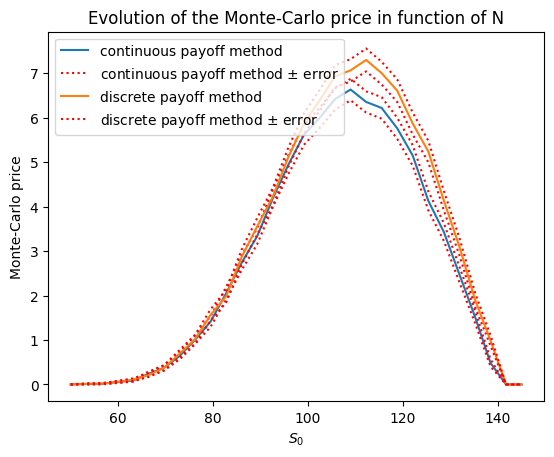

In [16]:
S_range = np.linspace(50, 145, 30)

_, ax = plt.subplots()
plot_montecarlo_prices(
    ax,
    S_range,
    continuous_payoff,
    "continuous payoff method",
    N=N,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=B,
)

plot_montecarlo_prices(
    ax,
    S_range,
    discrete_payoff,
    "discrete payoff method",
    N=N,
    n=100,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=B,
)
plt.show()


Les deux prix semblent les plus élevés autour de $100 \leq S_0\leq 130$, car c'est la zone avec le plus d'incertitude concernant le franchissement de la barrière $B$ et le payoff le plus élevé (tant que le payoff reste en dessous de $B$). Au-delà de $B$, le prix est nul car la barrière est déjà franchie à $S_0$ !

Les courbes de prix en fonction de $S_0$ sont similaires, néanmoins, on remarque une différence pour $100 \leq S_0\leq 130$ ; c'est dans cet intervalle que la barrière à le plus de chance d'être activé d'où l'incertitude plus grande.

2. Tracer le prix Monte Carlo (avec intervalle de confiance) de l’option d’achat à barrière
up-and-out (variante discrète) en fonction du nombre de dates d’observations. Ajouter le
prix Monte Carlo (avec intervalle de confiance) de la variante continue. Commenter.


In [19]:
def plot_montecarlo_n(ax, n_range, payoff_function, legend, **kwargs):
    """
    Utilitary function to plot the Monte-Carlo prices for different payoff functions.
    Parameters:
        ax: matplotlib.pyplot ax.
        n_range (Iterable[int]): Range of n for time series of underlying asset.
        payoff_function (Callable): Payoff function to compute the price.
        legend (str): Legend of the plot.
    """
    Cns, Cns_up, Cns_down = [], [], []
    for n in n_range:
        Cn, error_Cn = payoff_function(n=int(n), **kwargs)
        Cns.append(Cn)
        Cns_up.append(error_Cn[1])
        Cns_down.append(error_Cn[0])

    ax.plot(n_range, Cns, label=legend)
    ax.plot(
        n_range, Cns_up, linestyle=":", color="red", label=f"{legend} $\pm$ error"
    )
    ax.plot(n_range, Cns_down, linestyle=":", color="red")
    ax.set_xlabel("Number of time subdivisions")
    ax.set_ylabel("Monte-Carlo price")
    ax.set_title("Evolution of the Monte-Carlo price in function of n")
    ax.legend()

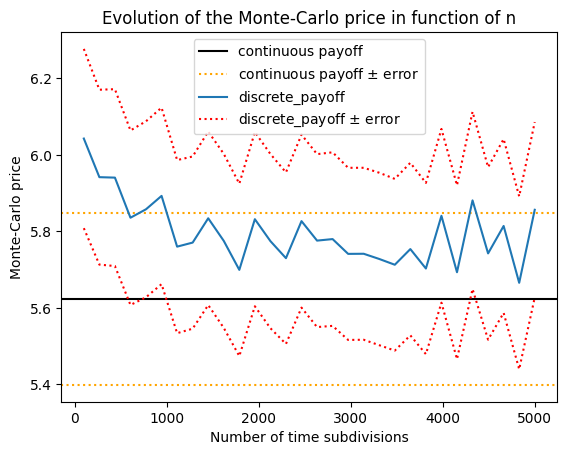

In [20]:
n_range = np.linspace(100, 5000, 30)

_, ax = plt.subplots()
Cn, errors = continuous_payoff(N, K, T, S0, r, sigma, B, alpha=0.01)
ax.axhline(Cn, color="black", label="continuous payoff")
ax.axhline(errors[0], linestyle=":", color="orange")
ax.axhline(errors[1], linestyle=":", color="orange", label=f"continuous payoff $\pm$ error")


plot_montecarlo_n(
    ax,
    n_range,
    discrete_payoff,
    "discrete_payoff",
    N=N,
    S0=S0,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=B,
)

plt.show()

Les deux prix semblent converger à mesure que $n\rightarrow \infty$.

3. Reprendre la question 1 pour un call down-and-in de niveau L.

On rappelle l'expression du payoff à $T$ d'un call down-and-in $ h(T) = (S_T -K)_+ \boldsymbol{1}_{\min\{S_1, \dots S_n\} \leq L}$.

On note que la solution pour le cas continu consiste à trouver la solution à l'équation polynomiale d'ordre 2 associée à $F_{M^X_t |X_t=x}(m|x)=y$ admet une unique solution plus petite que $x$ i.e. $m=\frac{x - \sqrt{x^2 - T\log(U)}}{2}$. Il nous suffit d'échantillonner $U\sim \mathcal{U}([0,1])$ et $x$ selon son expression usuelle pour estimer le payoff de façon continue avec la méthode de Monte-Carlo.

In [ ]:
def discrete_down_and_in_payoffs(N, n, K, T, S0, r, sigma, B):
    """
    Builds the discrete Monte-Carlo payoffs array for down-and-in option.
    Parameters:
        N (int): Sample size.
        n (int): Time-series length.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
    Returns:
        np.ndarray: The N Monte-Carlo payoffs of the down-and-in option call option.
    """

    mc_price = monte_carlo_discrete_path(N, n, T, S0, r, sigma)

    return np.maximum(0, mc_price[:, -1] - K) * np.any(mc_price < B, axis=1).astype(int)



def continuous_down_and_in_payoffs(N, K, T, S0, r, sigma, B):
    """
    Builds the continuous Monte-Carlo payoffs array for down-and-in option.
    Parameters:
        N (int): Sample size.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
    Returns:
        np.ndarray: The N Monte-Carlo payoffs of the down-and-in option call option.
    """

    mc_price, minima = monte_carlo_continuous(N, T, S0, r, sigma, sign=-1)

    return np.maximum(0, mc_price - K) * (minima < np.log(B / S0) / sigma).astype(int)



def discrete_down_and_in(N, n, K, T, S0, r, sigma, B, alpha=0.01):
    """
    Builds Monte-Carlo pricing using the discrete method for down-and-in option.
    Parameters:
        N (int): Sample size.
        n (int): Time-series length.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
        alpha (Optional[float]): Confidence interval threshold.
    Returns:
        (np.ndarray, np.ndarray): The N Monte-Carlo prices of the down-and-in option call option and the confidence interval.
    """

    payoffs = discrete_down_and_in_payoffs(
        N, n, K, T, S0, r, sigma, B
    )  # On construit les payoffs

    Cn = np.mean(np.exp(-r * T) * payoffs)  # On construit le prix à partir des payoffs

    return Cn, Cn + np.array(norm.interval(1 - alpha)) * np.exp(
        -r * T
    ) * standard_error(payoffs)



def continuous_down_and_in(N, K, T, S0, r, sigma, B, alpha=0.01):
    """
    Builds Monte-Carlo pricing using the continuous method for down-and-in option.
    Parameters:
        N (int): Sample size.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
        alpha (Optional[float]): Confidence interval threshold.
    Returns:
        (np.ndarray, np.ndarray): The N Monte-Carlo prices of the down-and-in option call option and the confidence interval.
    """

    payoffs = continuous_down_and_in_payoffs(
        N, K, T, S0, r, sigma, B
    )  # On construit les payoffs

    Cn = np.mean(np.exp(-r * T) * payoffs)  # On construit le prix à partir des payoffs

    interval = Cn + np.array(norm.interval(1 - alpha)) * np.exp(
        -r * T
    ) * standard_error(payoffs)
    del payoffs

    return Cn, interval

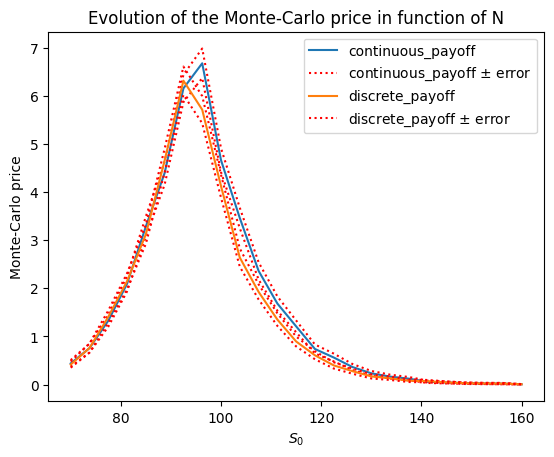

In [12]:
S_range = np.linspace(70, 160, 25)

_, ax = plt.subplots()
plot_montecarlo_prices(
    ax,
    S_range,
    continuous_down_and_in,
    "continuous_payoff",
    N=N,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=L,
)

plot_montecarlo_prices(
    ax,
    S_range,
    discrete_down_and_in,
    "discrete_payoff",
    N=N,
    n=100,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=L,
)
plt.show()

Les deux prix semblent les plus élevés autour de $80 \leq S_0\leq 120$, car c'est la zone avec le plus d'incertitude concernant le franchissement de la barrière $L$. Néanmoins, contrairement au cas d'options Up-and-out il n'y a pas de cas où le prix est nul d'emblée, car deux phénomènes contraires s'opposent:
- Si $S_T > K$ le payoff du call Européen est non nul.
- Si $\min\{S_1, \dots S_n\} \leq L$ l'indicatrice est non nulle. 
Pour que le payoff soit non-nul il faut que les deux termes soient non nuls.

Les courbes de prix en fonction de $S_0$ sont similaires, néanmoins, on remarque une différence autour de $S_0\simeq 100$ ; c'est dans cet intervalle que la barrière à le plus de chance d'être activé et que le payoff soit non nul d'où l'incertitude plus grande.

4. Implémenter un Monte Carlo conditionnel pour le pricing du call down-and-in (i.e. utiliser l’information disponible au franchissement de la barrière). Quel est le facteur de réduction de variance obtenu ? Comparer avec une réduction par variables antithétiques (comparer le coefficients de réduction obtenu et le théorique estimé par simulation). Commenter.

In [27]:
def reduced_discrete_down_and_in_payoffs(N, n, K, T, S0, r, sigma, B):
    """
    Builds the reduced (only those whose barrier is reached) discrete Monte-Carlo payoffs array for down-and-in option.
    Parameters:
        N (int): Sample size.
        n (int): Time-series length.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
    Returns:
        np.ndarray: The N Monte-Carlo payoffs of the down-and-in option call option.
    """
    mc_price = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    payoffs = np.maximum(0, mc_price[:, -1] - K)
    return np.where(np.any(mc_price < B, axis=1), payoffs, np.nan)


def reduced_continuous_down_and_in_payoffs(N, K, T, S0, r, sigma, B):
    """
    Builds the reduced (only those whose barrier is reached) continuous Monte-Carlo payoffs array for down-and-in option.
    Parameters:
        N (int): Sample size.
        n (int): Time-series length.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
    Returns:
        np.ndarray: The N Monte-Carlo payoffs of the down-and-in option call option.
    """
    mc_price, minima = monte_carlo_continuous(N, T, S0, r, sigma, sign=-1)
    payoffs = np.maximum(0, mc_price - K)
    return np.where(minima < np.log(B / S0) / sigma, payoffs, np.nan)


def reduced_discrete_down_and_in(N, n, K, T, S0, r, sigma, B, alpha=0.01):
    """
    Builds reduced (only those whose barrier is reached) Monte-Carlo prices using the discrete method for down-and-in option.
    Parameters:
        N (int): Sample size.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
        alpha (Optional[float]): Confidence interval threshold.
    Returns:
        (np.ndarray, np.ndarray): The N Monte-Carlo prices of the down-and-in option call option and the confidence interval.
    """
    payoffs = reduced_discrete_down_and_in_payoffs(N, n, K, T, S0, r, sigma, B)
    Cn = np.mean(np.exp(-r * T) * payoffs[~np.isnan(payoffs)])
    interval = Cn + np.array(norm.interval(1 - alpha)) * np.exp(
        -r * T
    ) * standard_error(payoffs[~np.isnan(payoffs)])
    del payoffs
    return Cn, interval



def reduced_continuous_down_and_in(N, K, T, S0, r, sigma, B, alpha=0.01):
    """
    Builds reduced (only those whose barrier is reached) Monte-Carlo prices using the continuous method for down-and-in option.
    Parameters:
        N (int): Sample size.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
        B (float): Barrier price.
        alpha (Optional[float]): Confidence interval threshold.
    Returns:
        (np.ndarray, np.ndarray): The N Monte-Carlo prices of the down-and-in option call option and the confidence interval.
    """
    payoffs = reduced_continuous_down_and_in_payoffs(N, K, T, S0, r, sigma, B)

    Cn = np.mean(np.exp(-r * T) * payoffs[~np.isnan(payoffs)])

    interval = Cn + np.array(norm.interval(1 - alpha)) * np.exp(
        -r * T
    ) * standard_error(payoffs[~np.isnan(payoffs)])
    del payoffs

    return Cn, interval

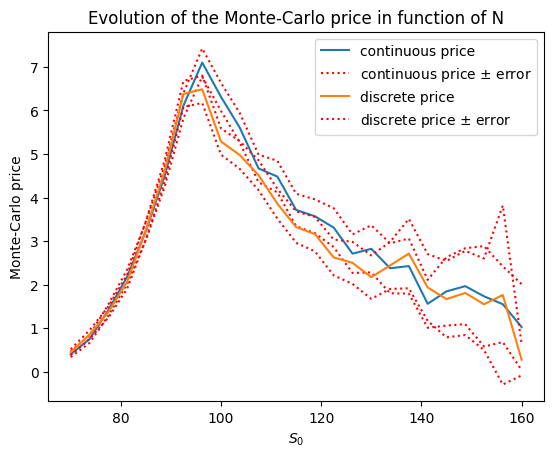

In [28]:
S_range = np.linspace(70, 160, 25)

_, ax = plt.subplots()
plot_montecarlo_prices(
    ax,
    S_range,
    reduced_continuous_down_and_in,
    "continuous price",
    N=N,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=L,
)

plot_montecarlo_prices(
    ax,
    S_range,
    reduced_discrete_down_and_in,
    "discrete price",
    N=N,
    n=100,
    K=K,
    T=T,
    r=r,
    sigma=sigma,
    B=L,
)

THe 

Text(0.5, 1.0, 'Standard deviation of the price in function of $S_0$')

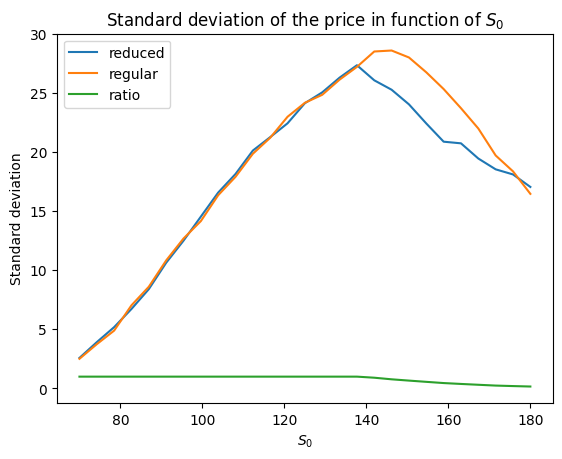

In [35]:
_, ax = plt.subplots()

std_dict = {"reduced": [], "regular": [], "ratio": []}

s_range = np.linspace(70, 180, 27)
for s in s_range:
    reduced_payoffs = reduced_discrete_down_and_in_payoffs(N, 500, K, T, s, r, sigma, B)
    payoffs = discrete_down_and_in_payoffs(N, 500, K, T, s, r, sigma, B)
    std_dict["reduced"].append(np.std(np.exp(-r * T) * reduced_payoffs[~np.isnan(reduced_payoffs)]))
    std_dict["regular"].append(np.std(np.exp(-r * T) * payoffs))
    std_dict["ratio"].append(len(reduced_payoffs[~np.isnan(reduced_payoffs)]) / len(payoffs))
pd.DataFrame(std_dict, index=s_range).plot(ax=ax)
ax.set_xlabel("$S_0$")
ax.set_ylabel("Standard deviation")
ax.set_title("Standard deviation of the price in function of $S_0$")